# xVA Desk Simulator: Portfolio Demo

This notebook demonstrates the capabilities of the `xva_desk_simulator` app: modeling, simulating, and visualizing xVA metrics (CVA, DVA, portfolio exposure) for a derivatives desk.

**Features demonstrated:**
- Flexible portfolio and counterparty setup
- Monte Carlo exposure simulation for multiple trades
- Portfolio aggregation, netting, and xVA calculation
- Scenario analysis and visualization


## Imports and Setup

Import all main modules and set random seed for reproducibility.


In [5]:
import sys
import os

# This adds the project root directory to Python's search path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

import numpy as np
from src.products import Derivative
from src.counterparty import Counterparty
from src.portfolio import Portfolio
from src.engine import simulate_spot_paths, expected_exposure_matrix, cva, dva
from src.utils import discount_curve
from src.report import plot_exposure


## Portfolio Construction

We will create a portfolio containing:
- An interest rate swap
- An FX forward
- A vanilla option (call)
All with the same counterparty, but different risk profiles.


In [6]:
# Trade details
swap = Derivative(2_000_000, 1.0, "swap", direction="receiver")
fx = Derivative(1_500_000, 1.0, "fx", direction="long")
option = Derivative(1_000_000, 1.0, "option", direction="receiver")

# Counterparty (SocGen as example)
counterparty = Counterparty("SocGen", hazard_rate=0.025, recovery_rate=0.4)

# Portfolio object
portfolio = Portfolio([swap, fx, option], counterparty)


## Simulate Market Scenarios

We simulate market evolution for the underlying risk factors using Geometric Brownian Motion.


In [7]:
# Simulation settings
S0 = 1.0       # Initial spot price
mu = 0.00
sigma = 0.22
T = 1.0
n_steps = 24
n_paths = 10000
r = 0.03
dt = T / n_steps

# Generate market scenarios
spot_paths, time_grid = simulate_spot_paths(S0, mu, sigma, T, n_steps, n_paths)
print(f"Simulated {n_paths} paths for {n_steps} time steps.")


Simulated 10000 paths for 24 time steps.


## Aggregate Portfolio Exposures

Calculate the net exposure of the whole portfolio over time and across scenarios.


In [8]:
exposures = portfolio.aggregate_exposure(spot_paths, time_grid)
EPE, ENE = expected_exposure_matrix(exposures)
print(f"EPE at time 0: {EPE[0]:,.2f}, ENE at time 0: {ENE[0]:,.2f}")


EPE at time 0: 100,000.00, ENE at time 0: -0.00


## Visualize Exposure Profiles

Plot Expected Positive Exposure (EPE) and Expected Negative Exposure (ENE) over the portfolio lifetime.


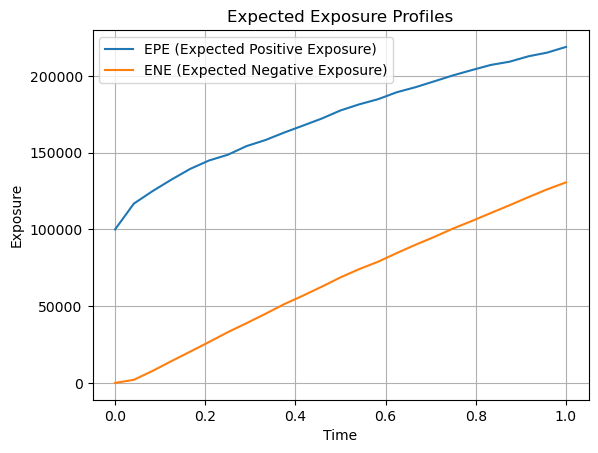

In [9]:
plot_exposure(time_grid, EPE, ENE)


## Calculate CVA and DVA

Apply standard xVA formulas using portfolio exposures, hazard rates, recovery, and discounting.


In [10]:
discount_factors = discount_curve(r, time_grid)
cva_val = cva(EPE, counterparty.hazard_rate, counterparty.recovery_rate, discount_factors, dt)
dva_val = dva(ENE, 0.015, counterparty.recovery_rate, discount_factors, dt)

print(f"CVA: ${cva_val:,.2f}")
print(f"DVA: ${dva_val:,.2f}")


CVA: $2,553.36
DVA: $604.27


## Scenario Analysis: Credit Spread Widening

Let's analyze the impact of a counterparty downgrade (hazard rate shock).


In [11]:
from src.scenarios import shock_hazard_rate, reset_hazard_rate

# Apply shock
old_hazard = shock_hazard_rate(counterparty, factor=1.5)
cva_shocked = cva(EPE, counterparty.hazard_rate, counterparty.recovery_rate, discount_factors, dt)
reset_hazard_rate(counterparty, old_hazard)

print(f"Stressed CVA (hazard rate x 1.5): ${cva_shocked:,.2f} (original: ${cva_val:,.2f})")
print(f"Increase: {((cva_shocked-cva_val)/cva_val)*100:.2f}%")


Stressed CVA (hazard rate x 1.5): $3,804.10 (original: $2,553.36)
Increase: 48.98%


## Conclusion

- This demo showed how to construct a portfolio, simulate market risk, and compute real desk-level xVA for multiple trades.
- Modular code structure allows extension: add collateral, advanced product models, or regulatory capital logic.
- This platform could be extended into a full xVA risk dashboard for real trading desks.

---

**See the [README.md](../README.md) for details, or run `app.py` for a CLI demo.**
